In [1]:
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
from scipy import stats
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.settings.n_jobs = 8
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)

In [2]:
cnt = pd.read_excel('data/hDRG_diabetes/hDRG_diabetes.xlsx', index_col=0).T
meta = pd.read_excel('data/hDRG_diabetes/hDRG_diabetes_meta.xlsx', index_col=0)

In [3]:
cnt.columns = cnt.columns.astype(str)
cnt.index = cnt.index.astype(str)

In [4]:
adata = sc.AnnData(cnt)
adata.obs[meta.columns] = meta
adata.obs.Condition = adata.obs.Condition.astype('category').cat.reorder_categories(['Healthy', 'Diabetic'])
adata.obs.Age = adata.obs.Age.astype(int)
sc.pp.filter_genes(adata, min_cells=3)
adata.var_names_make_unique()

filtered out 3203 genes that are detected in less than 3 cells


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_14462/3339975957.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(cnt)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [6]:
sc.pp.regress_out(adata, ['Sex'])
adata.layers['scaled'] = sc.pp.scale(adata.X)
adata.obsm['X_pca'] = sc.pp.pca(adata.layers['scaled'])

regressing out ['Sex']
    finished (0:00:04)
computing PCA
    with n_comps=11
    finished (0:00:00)


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


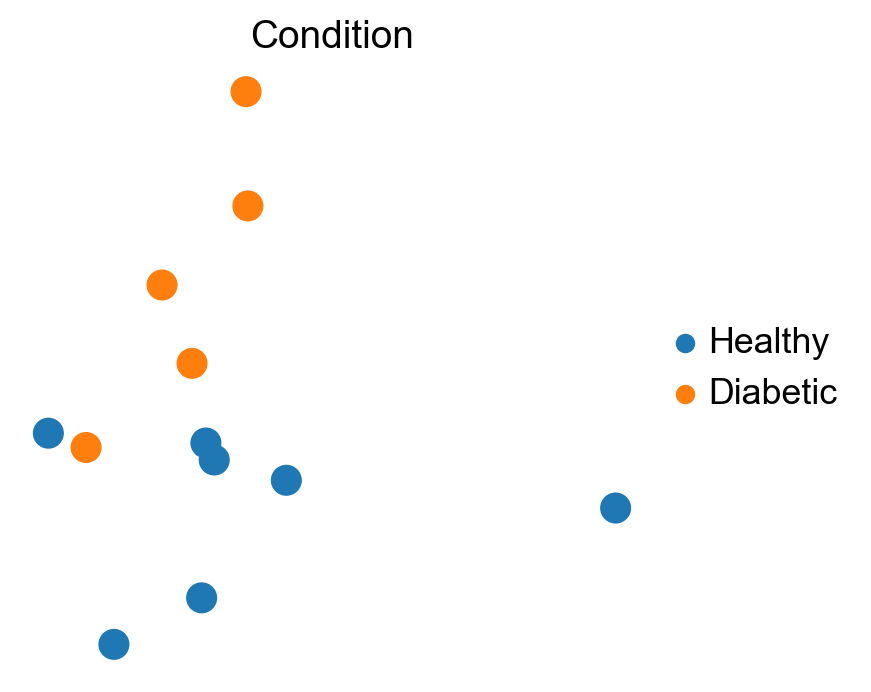

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


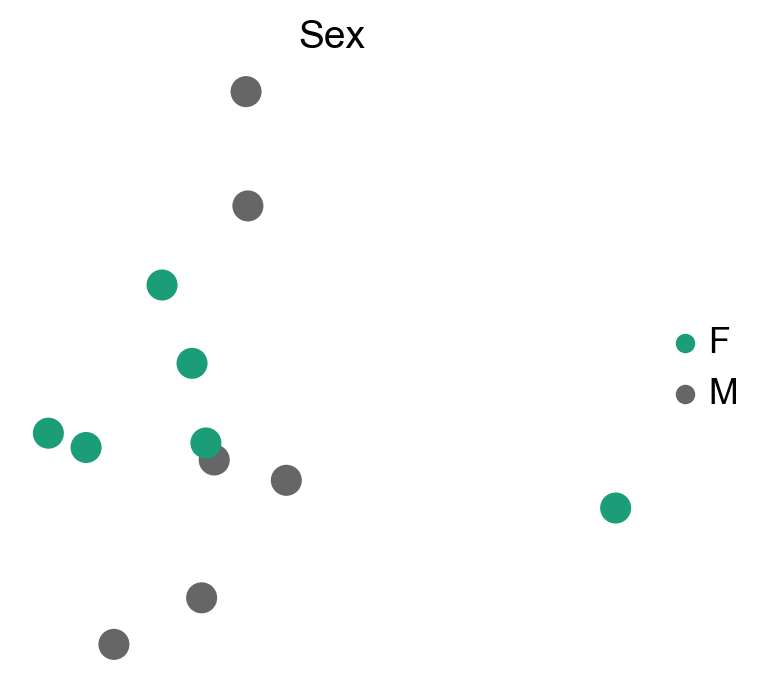

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


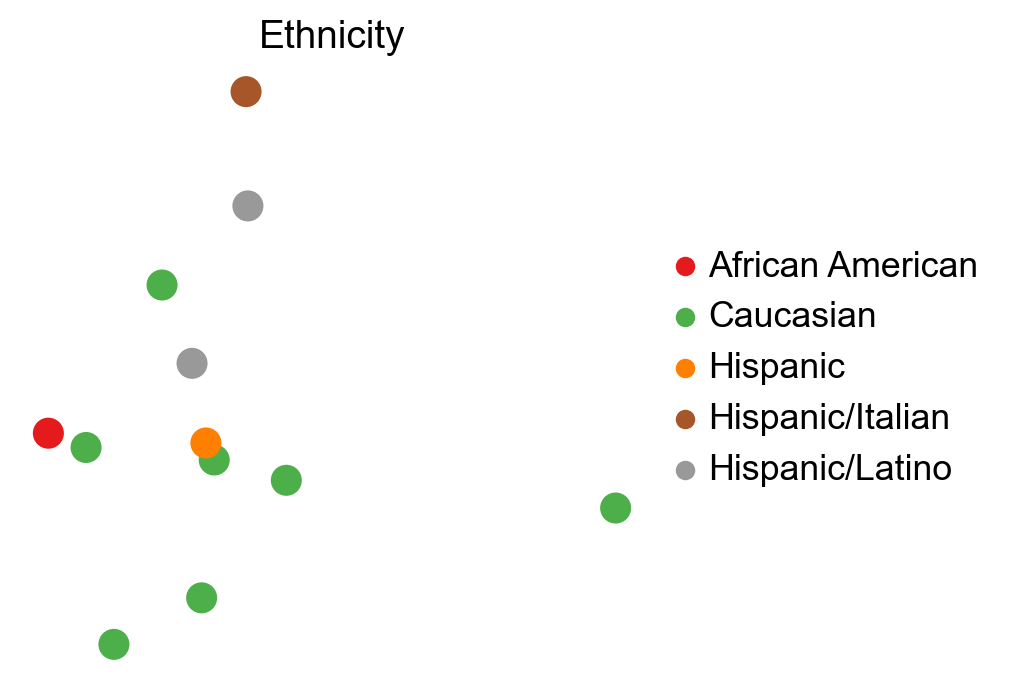

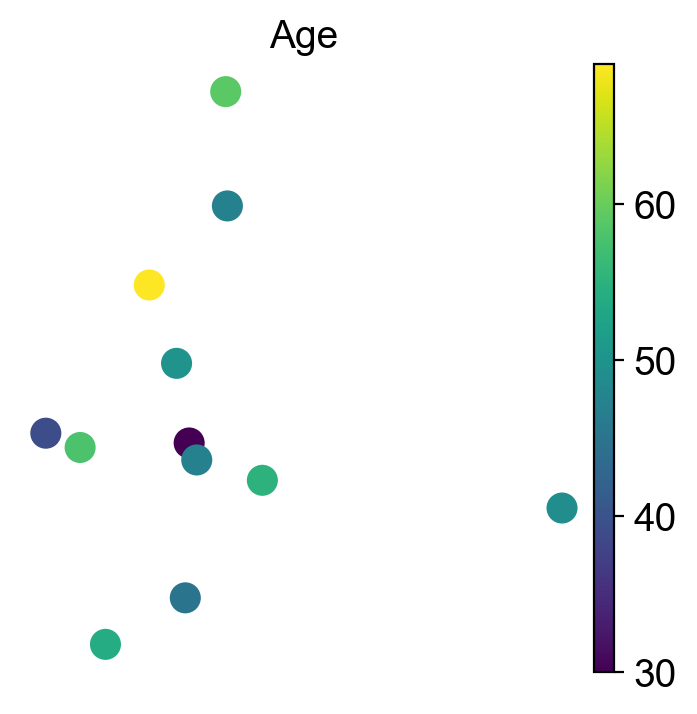

In [7]:
sc.pl.pca(adata, color=['Condition'], s=500)
sc.pl.pca(adata, color=['Sex'], s=500, palette='Dark2')
sc.pl.pca(adata, color=['Ethnicity'], s=500, palette='Set1')
sc.pl.pca(adata, color=['Age'], s=500)

In [8]:
def variance_explain(adata:sc.AnnData, covariates:list, n_pcs:int=50, use_rep:str='X_pca', n_jobs:int=8, method:str='lr'):
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from tqdm import tqdm
    
    # check if n_pcs is greater than the number of PCs available
    if n_pcs > adata.obsm[use_rep].shape[1]:
        print(f'Number of PCs requested is greater than the number of PCs available. Using {adata.obsm[use_rep].shape[1]} PCs instead.')
        n_pcs = adata.obsm[use_rep].shape[1]
        
    var_explained = pd.DataFrame(index=range(n_pcs), columns=covariates + ["overall"])
    for pc in tqdm(range(n_pcs), total=n_pcs):
        
        # check if the latent representation is present in adata.obsm
        try:
            y_true_unfiltered = adata.obsm[use_rep][:, pc]
        except KeyError:
            raise ValueError(f'{use_rep} not found in adata.obsm. Available keys are {list(adata.obsm.keys())}')
        
        var_explained.loc[pc, "overall"] = np.var(y_true_unfiltered)
        for cov in covariates:
            x = adata.obs[cov].values.copy()
            x_nans = x.isna() if not isinstance(x, np.ndarray) else np.isnan(x)
            x = x[~x_nans]
            if len(x) != 0:
                y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
                
                # check if the covariate is categorical
                if x.dtype in ["float32", "float", "float64"]:
                    x = x.reshape(-1, 1)
                else:
                    if len(set(x)) == 1:
                        var_explained.loc[pc, cov] = np.nan
                        continue
                    x = pd.get_dummies(x) # one-hot encoding for categorical variables
                
                # fit a regression model    
                if method == 'lr':
                    model = LinearRegression(fit_intercept=True).fit(
                        x,
                        y_true,
                    )
                elif method == 'rf':
                    model = RandomForestRegressor(criterion='squared_error', n_jobs=n_jobs, random_state=42).fit(
                        x,
                        y_true.ravel(),
                    )
                else:
                    raise ValueError('method should be either "lr" or "rf"')
                y_pred = model.predict(x) # predict the latent representation using the regression model
                var_explained.loc[pc, cov] = np.var(y_pred)
                
    # calculate the fraction of variance explained by each covariate
    total_variance_explained = np.sum(var_explained, axis=0).sort_values(ascending=False)
    total_variance_explained_fractions = (
        total_variance_explained / total_variance_explained["overall"]
    )
    return total_variance_explained_fractions

In [9]:
total_variance_explained_fractions = variance_explain(adata, ['Condition','Sex','Ethnicity'],
                                                      n_pcs=2, use_rep='X_pca', method='lr')

100%|██████████| 2/2 [00:00<00:00, 254.52it/s]


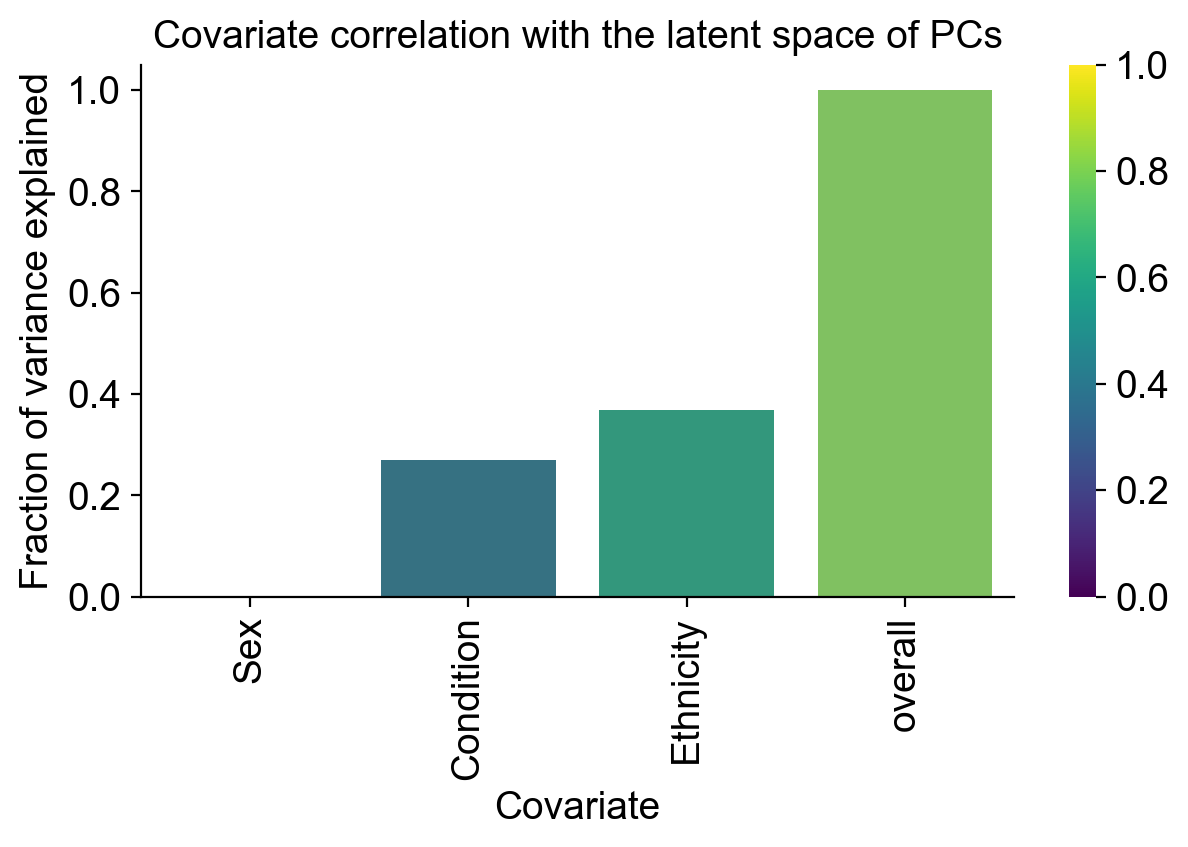

In [10]:
fig, ax = plt.subplots(figsize=(7, 3.5))
sns.barplot(x=total_variance_explained_fractions[::-1].index, y=total_variance_explained_fractions[::-1], ax=ax, palette="viridis")
ax.grid(False)
ax.set_ylabel("Fraction of variance explained")
ax.set_xlabel("Covariate")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
ax.set_title("Covariate correlation with the latent space of PCs")

norm = plt.Normalize(0, total_variance_explained_fractions.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
cbar = ax.figure.colorbar(sm, ax=ax, orientation="vertical")
cbar.outline.set_visible(False)

In [11]:
senmayo = pd.read_excel('../SenMayo.xlsx', sheet_name='human')['Gene(human)'].to_list()

In [12]:
adata.X = adata.layers['scaled'].copy()
sc.tl.score_genes(adata, senmayo, score_name='SenMayo', use_raw=False, ctrl_size=len(senmayo))
adata.X = adata.layers['log_norm'].copy()

computing score 'SenMayo'
    finished: added
    'SenMayo', score of gene set (adata.obs).
    1996 total control genes are used. (0:00:00)


In [13]:
adata.obs['SenMayo_Z'] = stats.gzscore(adata.obs.SenMayo+1)
adata.obs['SenMayo_Z'] = adata.obs['SenMayo_Z'].clip(-1.5,2)

In [16]:
test_df = adata.obs.copy()
test_df = test_df[(test_df.Age < 60) & (test_df.Age > 30)]

In [17]:
stats.ttest_ind(test_df[test_df.Condition=='Healthy'].Age, test_df[test_df.Condition=='Diabetic'].Age,
                permutations=10000, alternative='less')

Ttest_indResult(statistic=-1.3920446440226337, pvalue=0.10476190476190476)

In [18]:
stats.ttest_ind(test_df[test_df.Condition=='Healthy'].SenMayo_Z, test_df[test_df.Condition=='Diabetic'].SenMayo_Z,
                permutations=10000, alternative='less')

Ttest_indResult(statistic=-3.7948820717381726, pvalue=0.009523809523809525)

In [27]:
test_df.groupby('Condition').Sex.value_counts()

Condition  Sex
Healthy    M      4
           F      2
Diabetic   F      2
           M      2
Name: Sex, dtype: int64

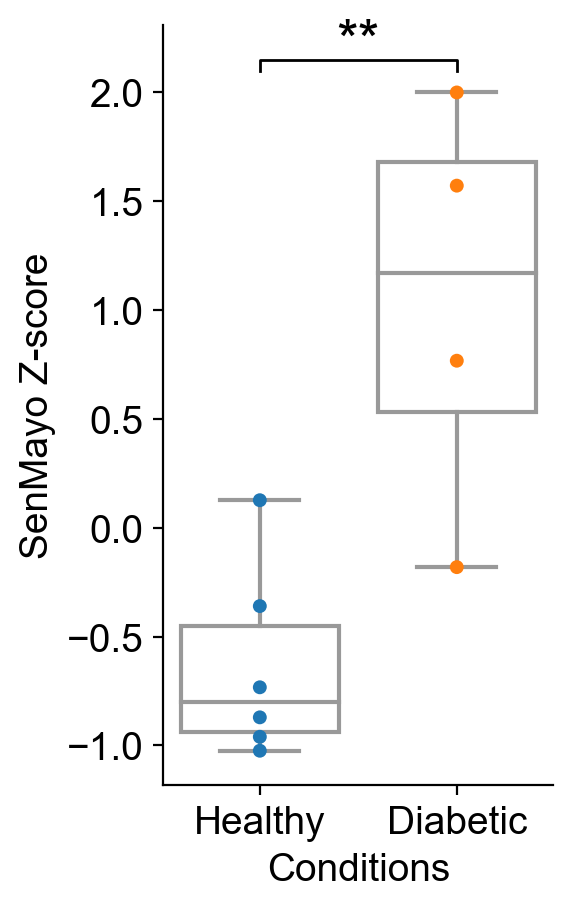

In [28]:
fig, ax = plt.subplots(figsize=(2.5,5))
sns.boxplot(x='Condition', y='SenMayo_Z', data=test_df, ax=ax, color='1', showfliers=False)
sns.swarmplot(x='Condition', y='SenMayo_Z', data=test_df, ax=ax, size=5, hue='Condition')
max_val = max(test_df.SenMayo_Z)
plt.plot([0,0,1,1], [max_val+0.1, max_val+0.15, max_val+0.15, max_val+0.1], lw=1, c='k')
plt.text(0.5, max_val+0.22, '**', ha='center', va='center', fontsize=20)
ax.grid(False)
ax.legend_.remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('SenMayo Z-score')
ax.set_xlabel('Conditions')
fig.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/Manu_fig/hDRG_diabetes_SenMayo.pdf', bbox_inches='tight', dpi=300)

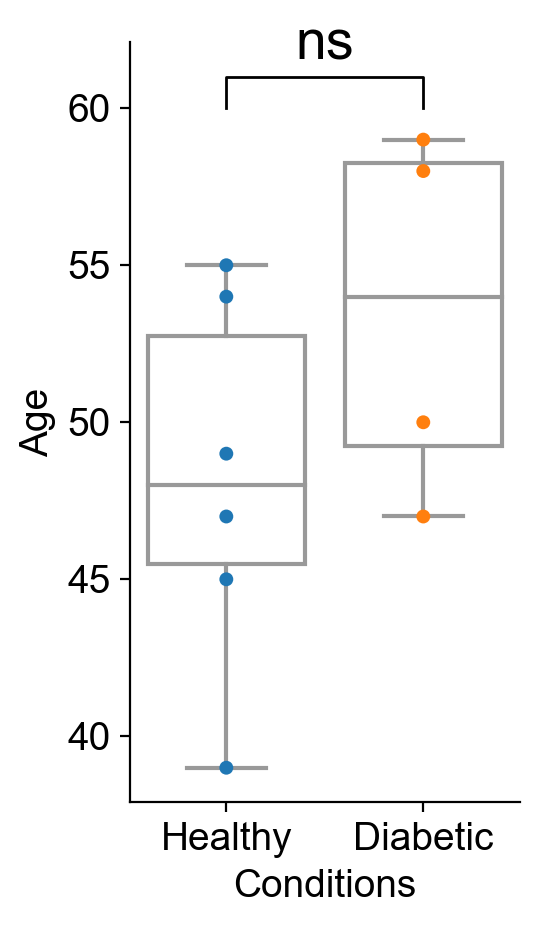

In [29]:
fig, ax = plt.subplots(figsize=(2.5,5))
sns.boxplot(x='Condition', y='Age', data=test_df, ax=ax, color='1', showfliers=False)
sns.swarmplot(x='Condition', y='Age', data=test_df, ax=ax, size=5, hue='Condition')
max_val = max(test_df.Age)
plt.plot([0,0,1,1], [max_val+1, max_val+2, max_val+2, max_val+1], lw=1, c='k')
plt.text(0.5, max_val+3, 'ns', ha='center', va='center', fontsize=20)
ax.grid(False)
ax.legend_.remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Age')
ax.set_xlabel('Conditions')
fig.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/Manu_fig/hDRG_diabetes_Age.pdf', bbox_inches='tight', dpi=300)